In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
from astropy.io import fits
from data_utils import *

# Synthetic data

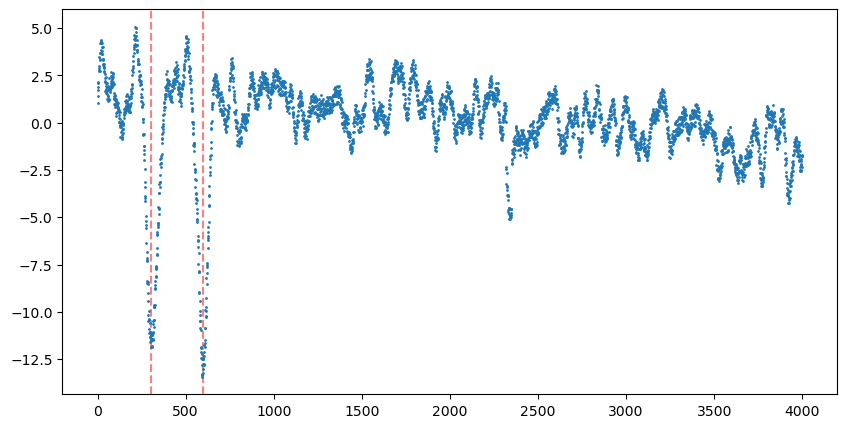

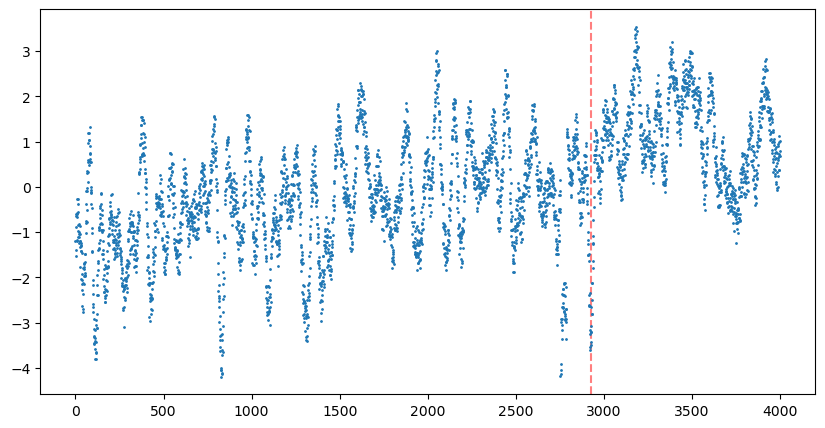

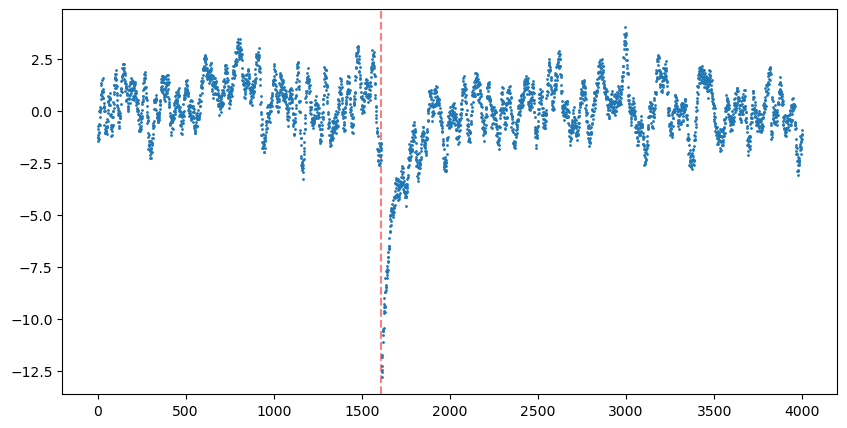

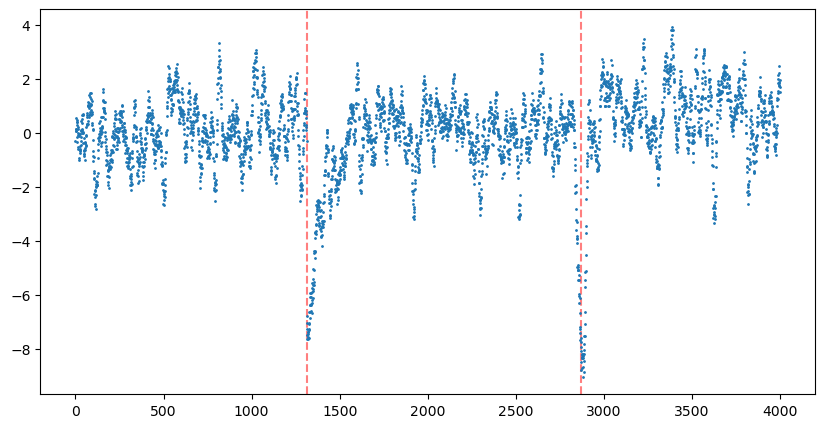

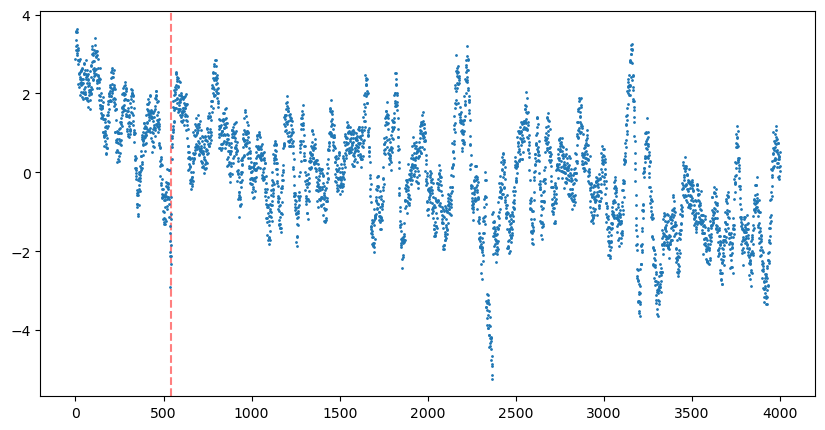

In [30]:
# create a few signals and plot them
for seed in range(15, 20):
    x, y, anomaly_locs = generate_synthetic_lc(num_steps=4000, seed=seed, num_anomalies=np.random.randint(0, 3), shapes=["gaussian", "saw"])
    plt.figure(figsize=(10,5))
    for i in range(len(anomaly_locs)):
        plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
    plt.plot(x, y, '.', markersize=2)
    plt.show()

# Injected anomaly

In [100]:
# Load a file and inject an anomaly
data_dir = '../data/k2/'
lcfile = 'k2_77.fits'
lchdu = fits.open(data_dir + lcfile)

# Load data
lcheader = lchdu[0].header
lcdata = lchdu[1].data
time = np.array(lcdata['TIME'])
pdcflux = np.array(lcdata['PDCSAP_FLUX'])
pdcerr = np.array(lcdata['PDCSAP_FLUX_ERR'])

x = time
y = pdcflux/np.nanmedian(pdcflux)
yerr = pdcerr/np.nanmedian(pdcflux)

# Remove nans and outliers
good = ((y < 1.5) & (y > 0.5) & (yerr > 0.))
x = x[good]
y = y[good]
yerr = np.abs(yerr[good]) 
x = x - np.min(x)

# bin to 30-minute cadence
nbins = int(np.floor((np.max(x)-np.min(x))*48)+1) # 48 bins per day
xbins = np.min(x)+ np.arange(nbins+1)/48.
numbinned, binedges = np.histogram(x,bins=xbins)
numbinned = np.array(numbinned)
ybinned, binedges = np.histogram(x,bins=xbins,weights=y)
varbinned, binedges = np.histogram(x,bins=xbins,weights=1/yerr**2)
yerrbinned = 1/np.sqrt(np.array(varbinned))
ybinned = np.array(ybinned)
ybinned = ybinned/(numbinned+0.001)
xbinned = xbins[0:nbins] + (xbins[1]-xbins[0])/2. 
x = xbinned
y = ybinned
yerr = yerrbinned
good = ((y > 0.) & ~np.isnan(yerr))
x = x[good]
y = y[good]
yerr = yerr[good]

t = y*0

npoints = len(x)
y_original = 1*y[:]

/tmp/ipykernel_907768/1022427511.py:31: RuntimeWarning: divide by zero encountered in divide
  yerrbinned = 1/np.sqrt(np.array(varbinned))


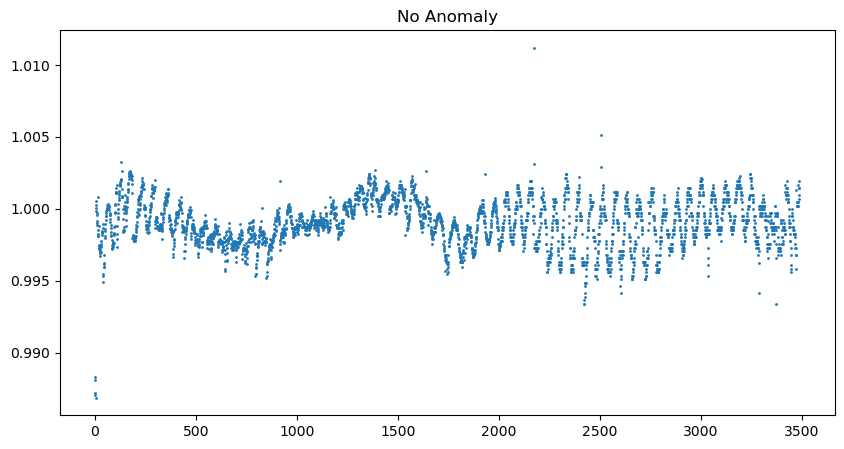

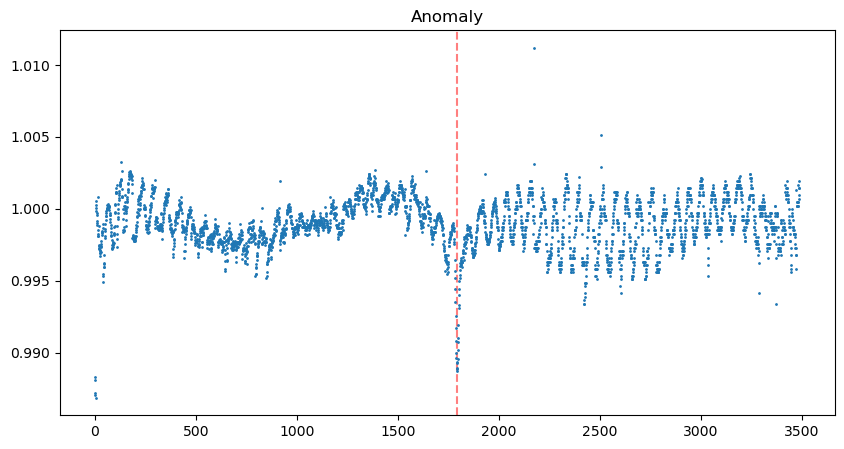

In [101]:
# Inject anomaly
steps, y, anomaly_locs = inject_anomaly(y, num_anomalies=1, seed=48)

# Plot
plt.figure(figsize=(10,5))
plt.plot(steps, y_original, '.', markersize=2)
plt.title("No Anomaly")

plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title("Anomaly")
plt.show()